# Implementation of Transhipment Problem as ILP 

## Library Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linprog
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value
import csv

## User input and graph visualization

In [2]:
def read_edges():
    print("Enter edges as (from, to, cost), one per line. Type 'done' when finished:")
    edges = []
    while True:
        line = input("Edge: ").strip()
        if line.lower() == 'done':
            break
        try:
            u, v, w = map(int, line.strip("()").split(","))
            edges.append((u, v, w))
        except:
            print("Invalid input. Please enter (from, to, cost).")
    return edges

def read_edges_from_csv(file_path):
    edges = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) == 3:
                u, v, w = map(int, row)
                edges.append((u, v, w))
    return edges

def build_cost_matrix(edges, num_nodes):
    cost_matrix = np.full((num_nodes, num_nodes), 0)
    for u, v, w in edges:
        cost_matrix[u][v] = w
    return cost_matrix

def visualize_graph(edges, flows=None):
    G = nx.DiGraph()
    for u, v, w in edges:
        label = f"{w}"
        if flows:
            label += f"\nflow={flows.get((u,v), 0):.1f}"
        G.add_edge(u, v, weight=w, label=label)
    
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Transshipment Network")
    plt.show()

## Implementation of Scipy and pUlp solvers for ILP

Choose input mode: [1] Manual [2] CSV file:  2
Enter CSV file path (e.g., edges.csv):  edges.csv


Enter supply/demand for each node (positive for supply, negative for demand):


Enter 3 values separated by space:  12 -4 -8



SciPy Linear Programming Result:
Success: True
Minimum Cost: 68.0
Flow Matrix:
 [[0. 4. 8.]
 [0. 0. 0.]
 [0. 0. 0.]]

PuLP Linear Programming Result:
Status: Optimal
Minimum Cost: 68.0
x0_0 = 0.0
x0_1 = 4.0
x0_2 = 8.0
x1_0 = 0.0
x1_1 = 0.0
x1_2 = 0.0
x2_0 = 0.0
x2_1 = 0.0
x2_2 = 0.0


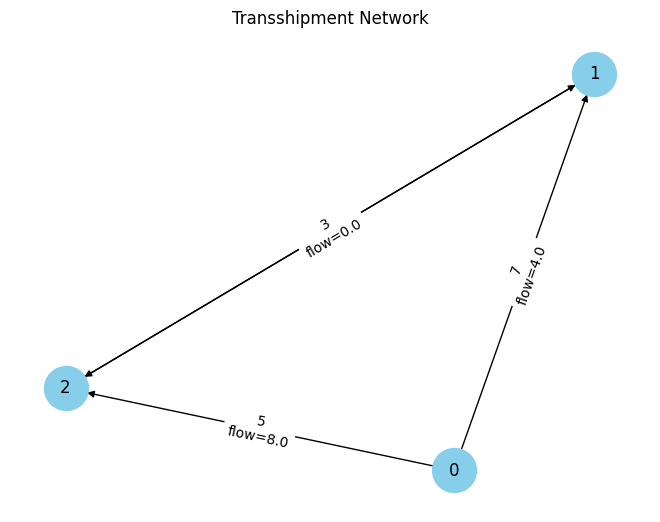

In [6]:
def main():
    mode = input("Choose input mode: [1] Manual [2] CSV file: ").strip()
    if mode == '2':
        path = input("Enter CSV file path (e.g., edges.csv): ").strip()
        edges = read_edges_from_csv(path)
    else:
        edges = read_edges()

    node_set = set()
    for u, v, _ in edges:
        node_set.update([u, v])
    num_nodes = max(node_set) + 1

    print("Enter supply/demand for each node (positive for supply, negative for demand):")
    supply_demand = list(map(int, input(f"Enter {num_nodes} values separated by space: ").split()))
    
    cost_matrix = build_cost_matrix(edges, num_nodes)
    c = cost_matrix.flatten()
    bounds = [(0, None)] * len(c)

    A_eq = []
    b_eq = []
    for i in range(num_nodes):
        constraint = [0] * (num_nodes * num_nodes)
        for j in range(num_nodes):
            constraint[i * num_nodes + j] += 1  # outflow
            constraint[j * num_nodes + i] -= 1  # inflow
        A_eq.append(constraint)
        b_eq.append(supply_demand[i])

    scipy_result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    print("\nSciPy Linear Programming Result:")
    print("Success:", scipy_result.success)
    print("Minimum Cost:", scipy_result.fun)
    flow_matrix = np.array(scipy_result.x).reshape((num_nodes, num_nodes))
    print("Flow Matrix:\n", flow_matrix)

    prob = LpProblem("Transshipment", LpMinimize)
    x_vars = [LpVariable(f"x{i}_{j}", lowBound=0) for i in range(num_nodes) for j in range(num_nodes)]

    prob += lpSum(c[i] * x_vars[i] for i in range(len(c)))

    for i in range(num_nodes):
        prob += lpSum(x_vars[i * num_nodes + j] for j in range(num_nodes)) - \
                lpSum(x_vars[j * num_nodes + i] for j in range(num_nodes)) == supply_demand[i]

    pulp_status = prob.solve()

    print("\nPuLP Linear Programming Result:")
    print("Status:", LpStatus[pulp_status])
    print("Minimum Cost:", value(prob.objective))

    flows = {}
    for v in prob.variables():
        i, j = map(int, v.name[1:].split("_"))
        flows[(i, j)] = v.varValue
        print(f"{v.name} = {v.varValue}")

    visualize_graph(edges, flows)

if __name__ == "__main__":
    main()